# Poisson Regression with a neural network mindset

This notebooks ilustrates the usage of a poisson regression approach as a neural network in comparison to other implementations both from baseline packages as the self proposed one using gradient descent.

## Simulation data

$$y \sim P(\lambda)$$

$$ \log{ \lambda } = \mathbf{X}\beta $$

where $\beta = [2,3]^T$ and $X$ is the design matrix given by

$$ \mathbf{X} = \begin{bmatrix}
    1 & X_{11}& X_{12} \\
    1 & X_{21}& X_{22} \\
    \vdots & \vdots & \vdots \\
    1 & X_{n1}& X_{n2} \\
\end{bmatrix} $$

* $X_1 = [x_{11} \dots x_{n1}]^T$ from an uniform distribution
* $X_2 = [x_{12} \dots x_{n2}]^T$ from an standard normal distribution

In [1]:
import os
import sys

import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import PoissonRegressor

from numpy.random import poisson, random, randn

src_path = os.path.dirname(os.getcwd())
sys.path.append(src_path)

from PoissonRegression.PoissonRegression import PoissonRegression 

n = 1000
np.random.seed(0)
x1 = random(n)
x2 = randn(n)

X = np.array([x1,x2]).T
w = np.array([2, 3])
b = np.ones(n)
syst = X @ w + b
y = poisson(np.exp(syst))

## Sklearn

In [2]:
RP_model = PoissonRegressor()
RP_model.fit(X,y)
print(RP_model.coef_)
print(RP_model.intercept_)

[1.95229544 2.98436462]
1.0671373317072548


## Statsmodels

In [3]:
X_desing = np.concatenate((np.ones(X.shape[0]).reshape(-1,1), X), axis = 1)
RP3_model = sm.GLM(y, X_desing, family=sm.families.Poisson()).fit()
print(RP3_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2447.4
Date:                Sun, 10 Dec 2023   Deviance:                       914.37
Time:                        18:21:27   Pearson chi2:                     933.
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9926      0.007    149.302      0.0

## Proposed approach

In [4]:
RP2_model = PoissonRegression()
RP2_model.fit(X,y)
print(RP2_model.coefs)
print(RP2_model.intercept)

[2.0053205  3.00224498]
0.9916320301459898


In [35]:
np.append(RP2_model.coefs,RP2_model.intercept)

array([2.0053205 , 3.00224498, 0.99163203])

## Neural network approach

In [25]:
import tensorflow as tf

nn_seq_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(2,), activation=tf.exp)
])

nn_seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [30]:
nn_seq_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='poisson'
)

hist = nn_seq_model.fit(
    X,y,
    batch_size=32,
    epochs=200,
    verbose=0
)

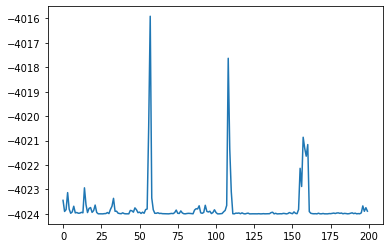

In [31]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.show()

In [32]:
np.argmin(hist.history['loss'])

119

In [39]:
nn_seq_model.get_weights()[1]

array([0.997088], dtype=float32)

In [40]:
np.append(np.append(RP2_model.coefs,RP2_model.intercept), np.append(nn_seq_model.get_weights()[0].reshape(1,-1), nn_seq_model.get_weights()[1]))

array([2.0053205 , 3.00224498, 0.99163203, 2.00386429, 3.00014377,
       0.99708802])

Next a more complex but less memory expensive and generalizable for future architectures is presented

## Batched data generator

In [2]:
import tensorflow as tf
from PoissonRegression.PoissonRegression import PoissonRegressionSyntheticData, PossionRegressionNN

poisson_regression_data = PoissonRegressionSyntheticData(
    w=tf.constant([2.,3.]), 
    b=1.,
    num_val=0,
    batch_size=32,
    seed=0
)
train_data_loader = poisson_regression_data.training_loader()

In [7]:
pr_model = PossionRegressionNN(train_data_loader.element_spec[0].shape.as_list())

pr_model.compile(
    optimizer = 'adam',
    loss = 'poisson'
)

hist = pr_model.fit(
    train_data_loader,
    epochs = 1000,
    verbose = 0
)

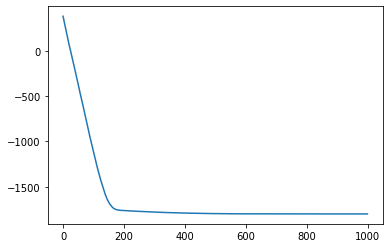

In [8]:
plt.plot(hist.history['loss'])
plt.show()

In [9]:
pr_model.get_weights()

[array([[2.0013452],
        [3.000377 ]], dtype=float32),
 array([0.9945376], dtype=float32)]

## Multiple scenarios analysis

Here we simulate multiple times and fit to the simulated data, to campare the mean fitted values for the parameters for each model, and the residuals of the estimations

In [44]:
def run_simulation(n:int=1000):
    """
    Function to run a simulation, fit the data
    and return the fitted parameters with each method
    """

    x1 = random(n)
    x2 = randn(n)

    X = np.array([x1,x2]).T
    w = np.array([2, 3])
    b = np.ones(n)
    syst = X @ w + b
    y = poisson(np.exp(syst))

    RP_model = PoissonRegressor()
    RP_model.fit(X,y)
    parameters = np.append(RP_model.intercept_, RP_model.coef_)

    X_desing = np.concatenate((np.ones(X.shape[0]).reshape(-1,1), X), axis = 1)
    RP2_model = sm.GLM(y, X_desing, family=sm.families.Poisson()).fit()
    parameters= np.append(parameters, RP2_model.params)

    RP3_model = PoissonRegression()
    RP3_model.fit(X,y)
    parameters = np.append(parameters, np.append(RP3_model.intercept, RP3_model.coefs))

    RP4_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, input_shape=(2,), activation=tf.exp)
    ])
    RP4_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss='poisson'
    )
    RP4_model.fit(
        X,y,
        batch_size=32,
        epochs=300,
        verbose=0
    )
    parameters = np.append(
        parameters, 
        np.append(RP4_model.get_weights()[1], RP4_model.get_weights()[0].reshape(1,-1))
    )    

    return parameters

In [46]:
sim_results = np.concatenate(
    [run_simulation().reshape(1, -1) for _ in range(1000)], axis = 0
)

In [47]:
sklearn_b0 = sim_results[:,0]
sklearn_b1 = sim_results[:,1]
sklearn_b2 = sim_results[:,2]

print("mean beta0 stimated: ", np.mean(sklearn_b0))
print("mean beta1 stimated: ", np.mean(sklearn_b1))
print("mean beta2 stimated: ", np.mean(sklearn_b2))

mean beta0 stimated:  1.0832704357365535
mean beta1 stimated:  1.9303004476438306
mean beta2 stimated:  2.982990813467288


In [48]:
sklearn_b0_error = sklearn_b0 - 1
sklearn_b1_error = sklearn_b1 - 2 
sklearn_b2_error = sklearn_b2 - 3

print("mean beta0 error: ", np.mean(sklearn_b0_error))
print("mean beta1 error: ", np.mean(sklearn_b1_error))
print("mean beta2 error: ", np.mean(sklearn_b2_error))
print("beta0 errors sd: ", np.std(sklearn_b0_error))
print("beta1 errors sd: ", np.std(sklearn_b1_error))
print("beta2 errors sd: ", np.std(sklearn_b2_error))

mean beta0 error:  0.08327043573655363
mean beta1 error:  -0.06969955235616968
mean beta2 error:  -0.017009186532712193
beta0 errors sd:  0.03646777865087278
beta1 errors sd:  0.02852794724263913
beta2 errors sd:  0.012377592791337046


In [49]:
statsmodels_b0 = sim_results[:,3]
statsmodels_b1 = sim_results[:,4]
statsmodels_b2 = sim_results[:,5]

print("mean beta0 stimated: ", np.mean(statsmodels_b0))
print("mean beta1 stimated: ", np.mean(statsmodels_b1))
print("mean beta2 stimated: ", np.mean(statsmodels_b2))

mean beta0 stimated:  1.000220380693111
mean beta1 stimated:  1.9998760209211397
mean beta2 stimated:  2.99990456820966


In [50]:
statsmodels_b0_error = statsmodels_b0 - 1
statsmodels_b1_error = statsmodels_b1 - 2 
statsmodels_b2_error = statsmodels_b2 - 3

print("mean beta0 error: ", np.mean(statsmodels_b0_error))
print("mean beta1 error: ", np.mean(statsmodels_b1_error))
print("mean beta2 error: ", np.mean(statsmodels_b2_error))
print("beta0 errors sd: ", np.std(statsmodels_b0_error))
print("beta1 errors sd: ", np.std(statsmodels_b1_error))
print("beta2 errors sd: ", np.std(statsmodels_b2_error))

mean beta0 error:  0.00022038069311102192
mean beta1 error:  -0.00012397907886004233
mean beta2 error:  -9.543179033932202e-05
beta0 errors sd:  0.007011406414701769
beta1 errors sd:  0.005693986580258361
beta2 errors sd:  0.002282654791936761


In [51]:
proposed_module_b0 = sim_results[:,6]
proposed_module_b1 = sim_results[:,7]
proposed_module_b2 = sim_results[:,8]

print("mean beta0 stimated: ", np.mean(proposed_module_b0))
print("mean beta1 stimated: ", np.mean(proposed_module_b1))
print("mean beta2 stimated: ", np.mean(proposed_module_b2))

mean beta0 stimated:  0.997009659618766
mean beta1 stimated:  2.000447796399969
mean beta2 stimated:  3.0013727700300543


In [52]:
proposed_module_b0_error = proposed_module_b0 - 1
proposed_module_b1_error = proposed_module_b1 - 2 
proposed_module_b2_error = proposed_module_b2 - 3

print("mean beta0 error: ", np.mean(proposed_module_b0_error))
print("mean beta1 error: ", np.mean(proposed_module_b1_error))
print("mean beta2 error: ", np.mean(proposed_module_b2_error))
print("beta0 errors sd: ", np.std(proposed_module_b0_error))
print("beta1 errors sd: ", np.std(proposed_module_b1_error))
print("beta2 errors sd: ", np.std(proposed_module_b2_error))

mean beta0 error:  -0.002990340381234016
mean beta1 error:  0.00044779639996882014
mean beta2 error:  0.0013727700300540434
beta0 errors sd:  0.010572169251878084
beta1 errors sd:  0.009771056645942754
beta2 errors sd:  0.004666495849065589


In [53]:
neural_network_b0 = sim_results[:,9]
neural_network_b1 = sim_results[:,10]
neural_network_b2 = sim_results[:,11]

print("mean beta0 stimated: ", np.mean(neural_network_b0))
print("mean beta1 stimated: ", np.mean(neural_network_b1))
print("mean beta2 stimated: ", np.mean(neural_network_b2))

mean beta0 stimated:  1.0148137271404267
mean beta1 stimated:  1.989585751414299
mean beta2 stimated:  2.9970455939769747


In [58]:
neural_network_b0_error = neural_network_b0 - 1
neural_network_b1_error = neural_network_b1 - 2 
neural_network_b2_error = neural_network_b2 - 3

print("mean beta0 error: ", np.mean(neural_network_b0_error))
print("mean beta1 error: ", np.mean(neural_network_b1_error))
print("mean beta2 error: ", np.mean(neural_network_b2_error))
print("beta0 errors sd: ", np.std(neural_network_b0_error))
print("beta1 errors sd: ", np.std(neural_network_b1_error))
print("beta2 errors sd: ", np.std(neural_network_b2_error))

mean beta0 error:  0.014813727140426636
mean beta1 error:  -0.010414248585700989
mean beta2 error:  -0.0029544060230255126
beta0 errors sd:  0.07886681435409162
beta1 errors sd:  0.06988875041718458
beta2 errors sd:  0.014892512011879506


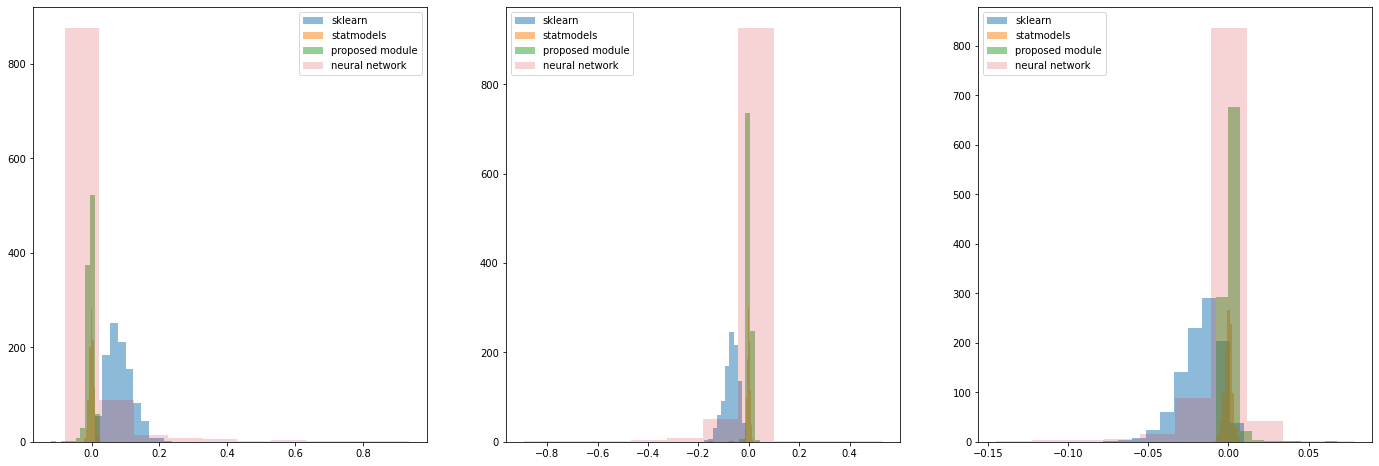

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))

ax1.hist(sklearn_b0_error, label="sklearn", alpha =0.5)
ax1.hist(statsmodels_b0_error, label="statmodels", alpha =0.5)
ax1.hist(proposed_module_b0_error, label="proposed module", alpha =0.5)
ax1.hist(neural_network_b0_error, label="neural network", alpha =0.2)
ax1.legend()

ax2.hist(sklearn_b1_error, label="sklearn", alpha =0.5)
ax2.hist(statsmodels_b1_error, label="statmodels", alpha =0.5)
ax2.hist(proposed_module_b1_error, label="proposed module", alpha =0.5)
ax2.hist(neural_network_b1_error, label="neural network", alpha =0.2)
ax2.legend()

ax3.hist(sklearn_b2_error, label="sklearn", alpha =0.5)
ax3.hist(statsmodels_b2_error, label="statmodels", alpha =0.5)
ax3.hist(proposed_module_b2_error, label="proposed module", alpha =0.5)
ax3.hist(neural_network_b2_error, label="neural network", alpha =0.2)
ax3.legend()

plt.show()